# Analyse model performences 

In [1]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
import re

In [2]:
# Directories with results
hist_dir = '../history'
img_dir = '../images'

# The different models we tested
multimodal_SALICON = 'multimodal_SALICON_v1'
multimodal_SALICON_no_dense = 'multimodal_SALICON_no_dense'
multimodal_capgaze1 = 'multimodal_capgaze1_v1'
multimodal_capgaze1_not_pretrained = 'multimodal_capgaze1_not_pretrained'

baseline_SALICON = 'baseline_SALICON_v1'
baseline_capgaze1 = 'baseline_capgaze1_v1'
baseline_capgaze1_not_pretrained = 'baseline_capgaze1_not_pretrained'

# loss and metrics
train_cols = ['train_loss','train_AUC','train_CC','train_NSS','train_KLDiv','train_SIM']
test_cols = ['test_loss','test_AUC','test_CC','test_NSS','test_KLDiv','test_SIM']

# colormap
colors = sns.color_palette("Paired")

## Create summaries showing the performance of the different models

In [3]:
def create_dfs(model, hist_dir, train_cols, test_cols):
    model_path = f'{hist_dir}/{model}'
    natsort = lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split('(\d+)', s)]
    files = [file for file in os.listdir(model_path) if file[-4:] == '.csv']
    df = pd.concat([pd.read_csv(f'{model_path}/{file}') for file in sorted(files, key=natsort)], ignore_index=True)
    df = df.drop_duplicates().reset_index(drop=True)
    test_df = df.drop(train_cols, axis=1)
    train_df = df.drop(test_cols, axis=1)
    epochs = len(files)
    
    return train_df, test_df, epochs

def plot_losses(model, train_df, test_df, epochs, colors):
    test_loss = test_df['test_loss'].to_numpy()
    train_loss = train_df['train_loss'].to_numpy()
    
    fig, ax = plt.subplots()
    ax.plot(test_loss, label='test_loss', color=colors[0])
    ax.plot(train_loss, label='train_loss', color=colors[0], linestyle='dashed')
    ax.set_xticks(np.arange(0, epochs+1, 2))
    ax.set_title(f"Changes in the train and test loss of {model} during training", fontsize=10, y=1.01)
    ax.legend()
    
    plt.savefig(f'loss_{model}.png')
    plt.show();
    
def plot_metrics(model, train_df, test_df, epochs, colors):
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharex=True)
    fig.suptitle(f"Changes in the train and test metrics of {model} during training", fontsize=18, y=1.01)
    
    for train_metric, test_metric, ax, col in zip(train_cols[1:], test_cols[1:], axs.ravel(), colors[2:11:2]):
        train_df[train_metric].plot(label=train_metric, color=col, ax=ax)
        test_df[test_metric].plot(label=test_metric, color=col, linestyle='dashed', ax=ax)
        
        ax.set_title(train_metric.split('_')[1])
        ax.set_xticks(np.arange(0, epochs+1, 5))
        ax.legend()
        
    plt.savefig(f'metrics_{model}.png')
    plt.show();
        
def show_preds(model, img_dir, epochs):
    pred = Image.open(f'{img_dir}/{model}/epoch_test_{epochs-1}.png')
    plt.imshow(pred)
    plt.axis('off')
    plt.title(f"Predicted saliency maps of {model} after {epochs} epochs of training", fontsize=8, y=1.01)
        
def print_performance(test_df):
    new_col_names = [col_name.split('_')[1] for col_name in test_df.columns]
    test_df.columns = new_col_names
    print(test_df.iloc[-1].drop('loss'))

def create_summary(model, hist_dir, img_dir, train_cols, test_cols, colors):
    print(f'Summary of the performance of {model}:')
    train_df, test_df, epochs = create_dfs(model, hist_dir, train_cols, test_cols)
    show_preds(model, img_dir, epochs)
    plot_losses(model, train_df, test_df, epochs, colors)
    plot_metrics(model, train_df, test_df, epochs, colors)
    print_performance(test_df)

Summary of the performance of multimodal_SALICON_v1:


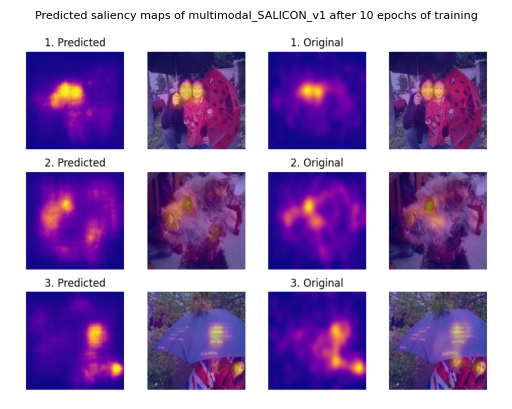

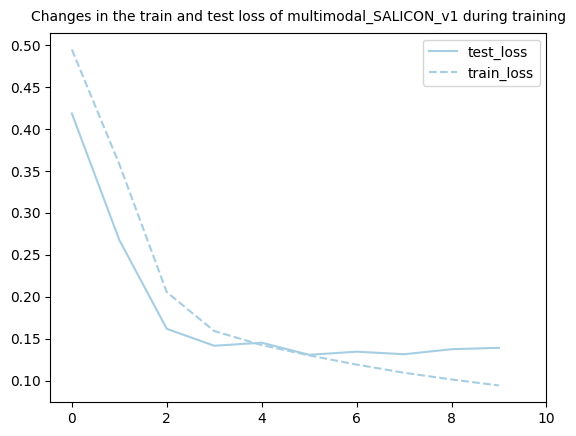

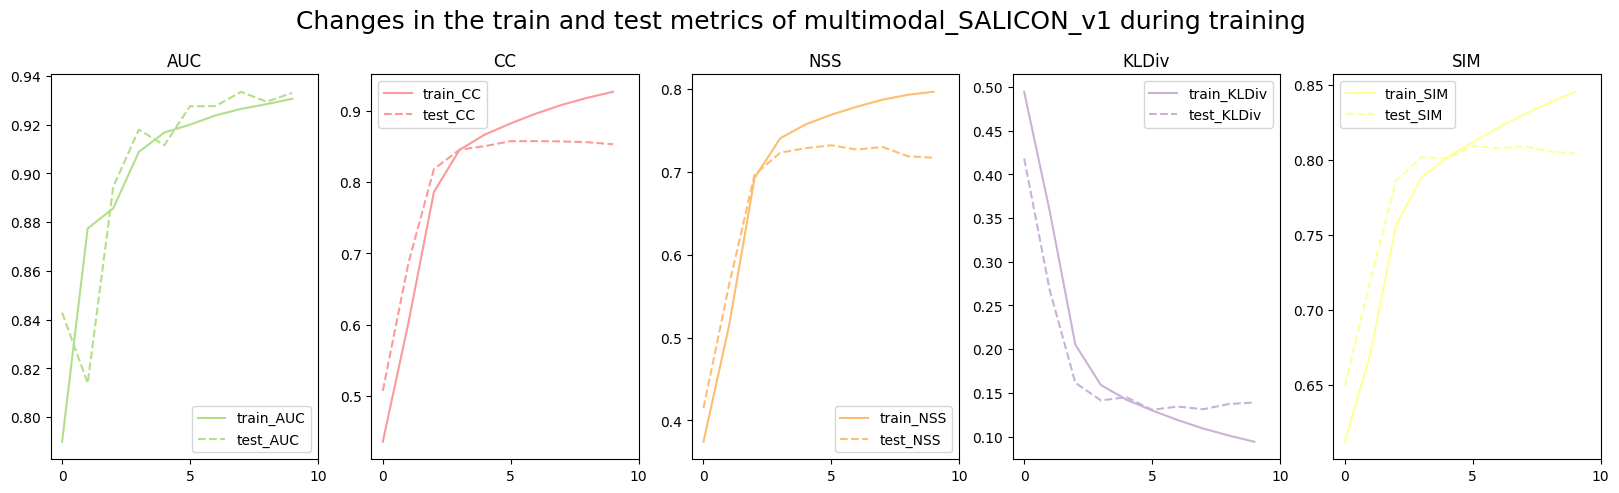

AUC      0.932986
CC       0.852837
NSS      0.717137
KLDiv    0.138976
SIM      0.804061
Name: 9, dtype: float64


In [4]:
create_summary(multimodal_SALICON, hist_dir, img_dir, train_cols, test_cols, colors)

Summary of the performance of multimodal_capgaze1_v1:


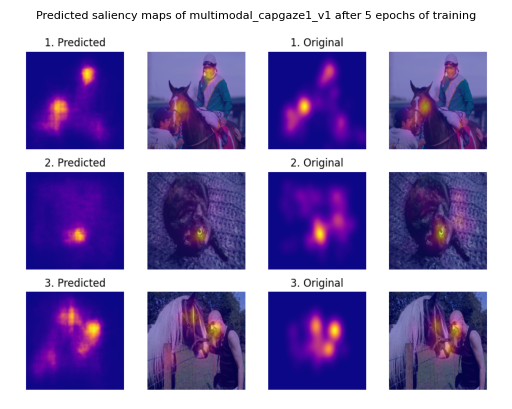

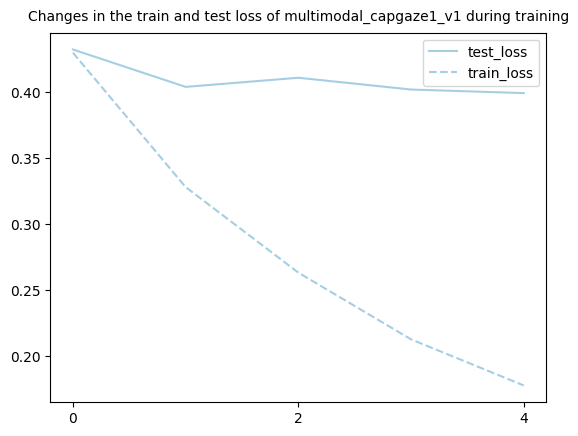

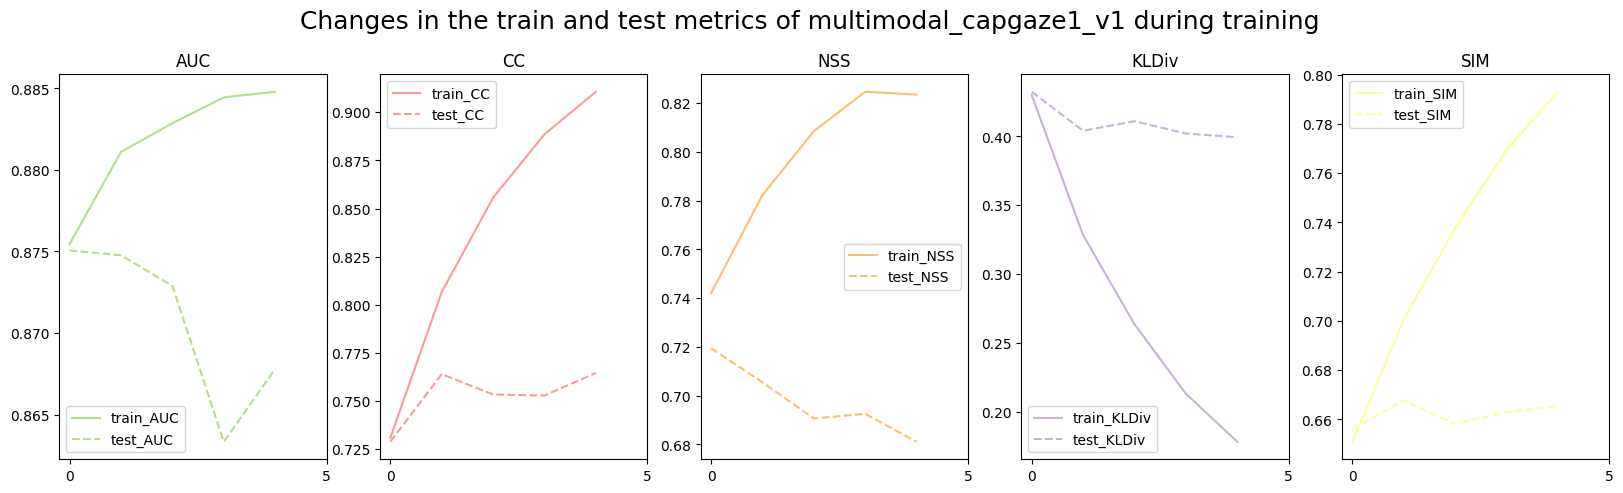

AUC      0.867802
CC       0.764667
NSS      0.681062
KLDiv    0.399393
SIM      0.665339
Name: 4, dtype: float64


In [5]:
create_summary(multimodal_capgaze1, hist_dir, img_dir, train_cols, test_cols, colors)

Summary of the performance of multimodal_capgaze1_not_pretrained:


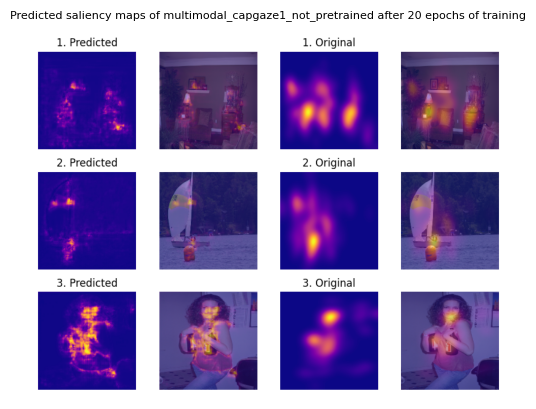

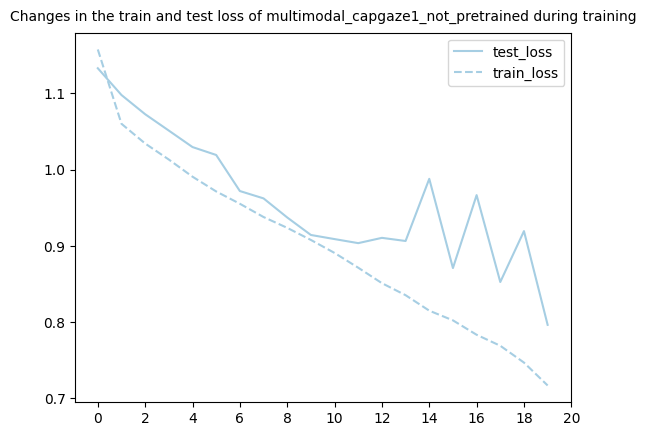

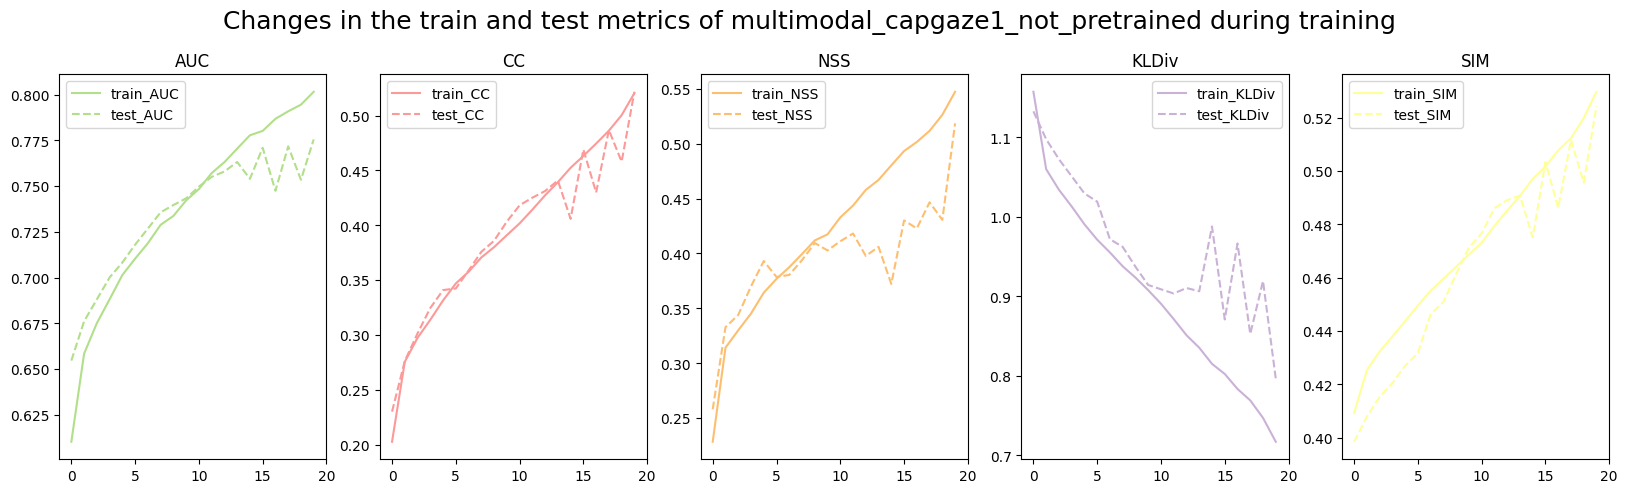

AUC      0.775524
CC       0.521717
NSS      0.518498
KLDiv    0.796498
SIM      0.524302
Name: 19, dtype: float64


In [6]:
create_summary(multimodal_capgaze1_not_pretrained, hist_dir, img_dir, train_cols, test_cols, colors)

Summary of the performance of baseline_SALICON_v1:


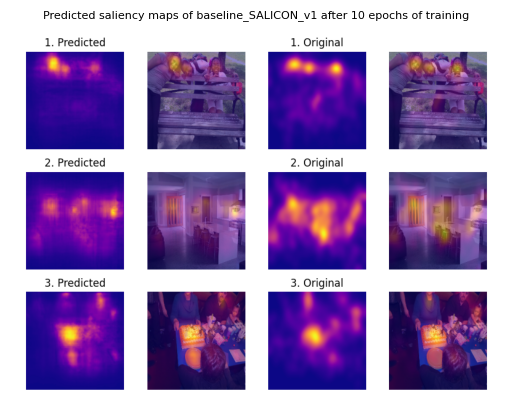

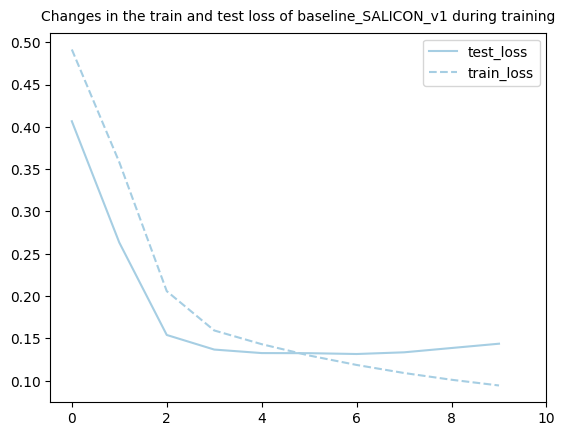

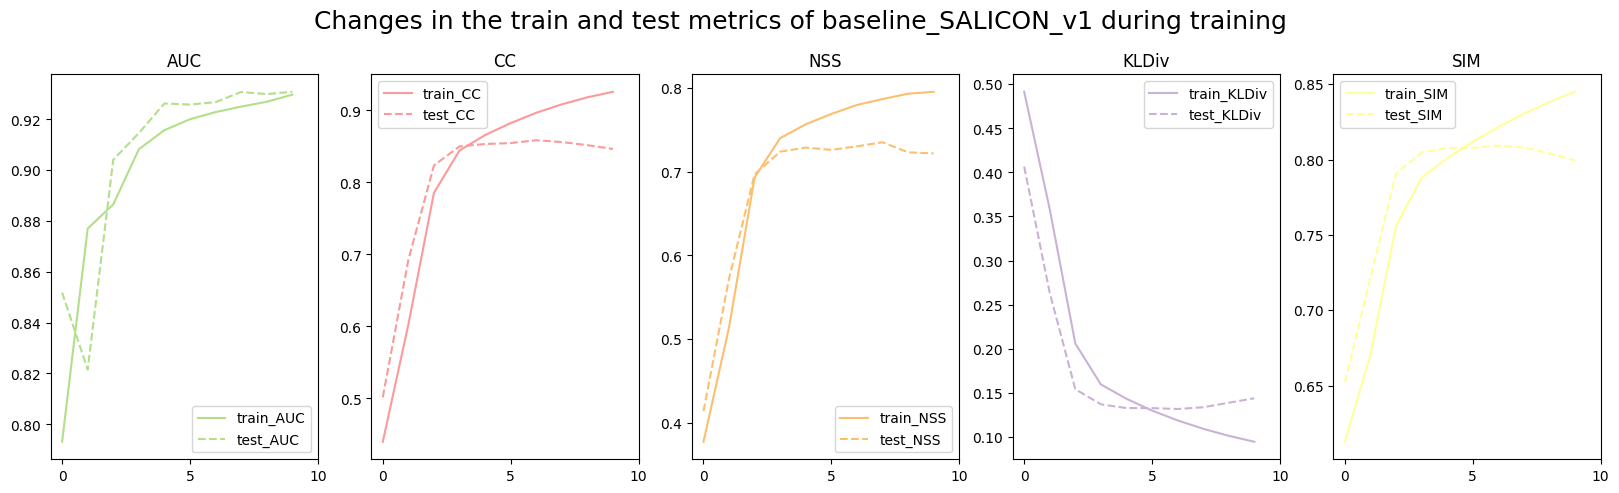

AUC      0.930863
CC       0.846381
NSS      0.721845
KLDiv    0.143721
SIM      0.799354
Name: 9, dtype: float64


In [7]:
create_summary(baseline_SALICON, hist_dir, img_dir, train_cols, test_cols, colors)

Summary of the performance of baseline_capgaze1_v1:


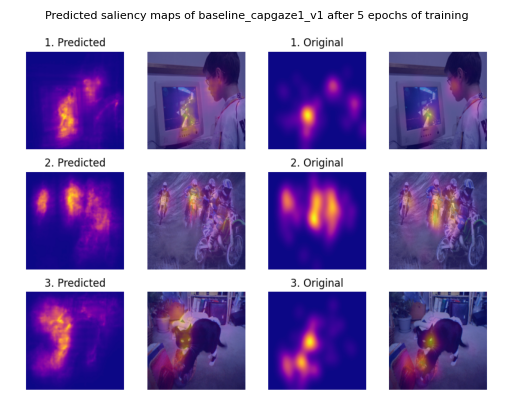

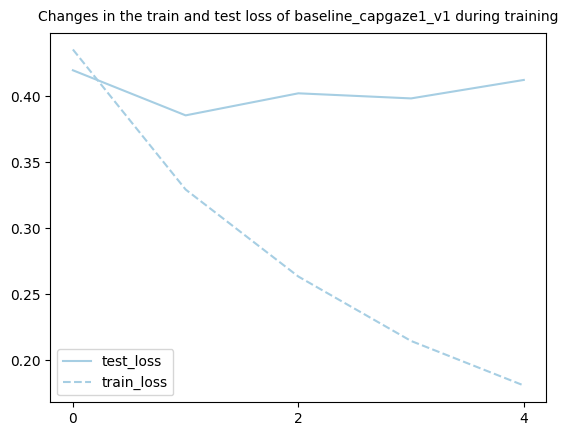

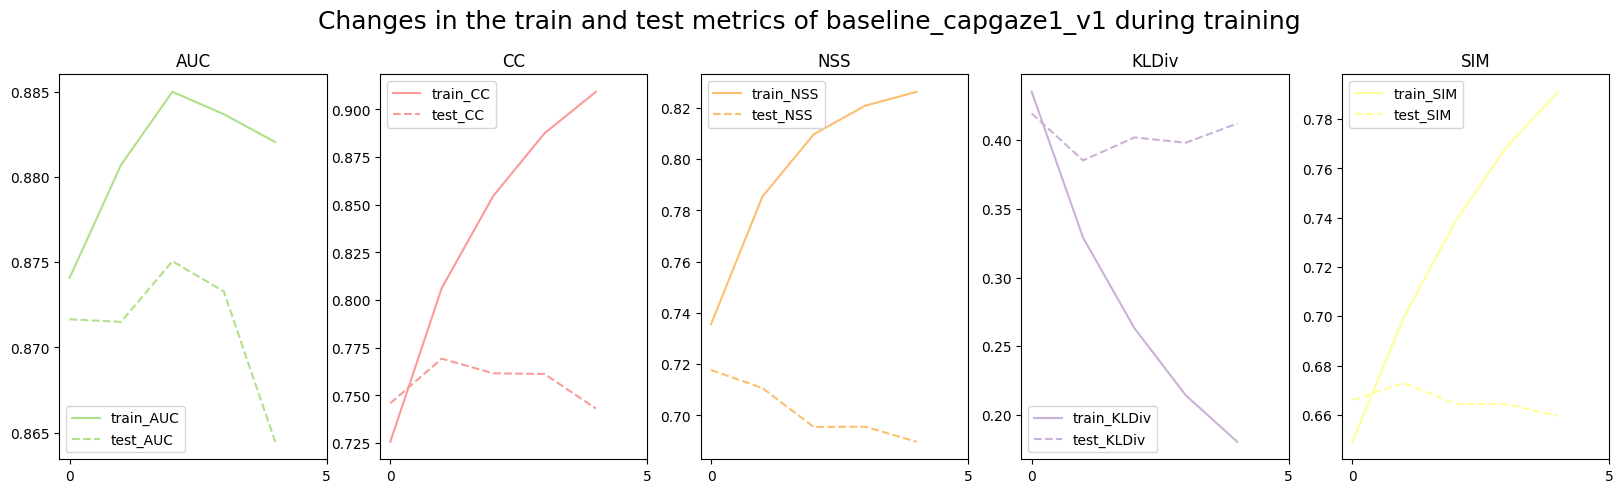

AUC      0.864460
CC       0.743042
NSS      0.689719
KLDiv    0.411965
SIM      0.659516
Name: 4, dtype: float64


In [8]:
create_summary(baseline_capgaze1, hist_dir, img_dir, train_cols, test_cols, colors)

Summary of the performance of baseline_capgaze1_not_pretrained:


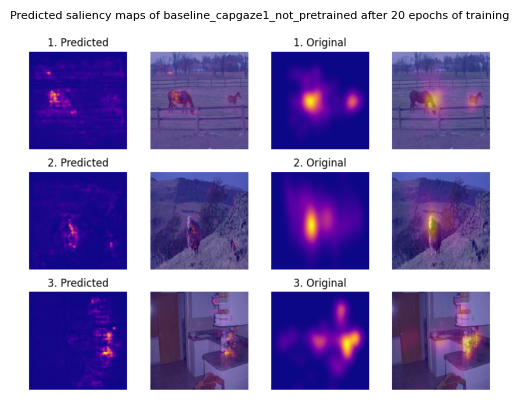

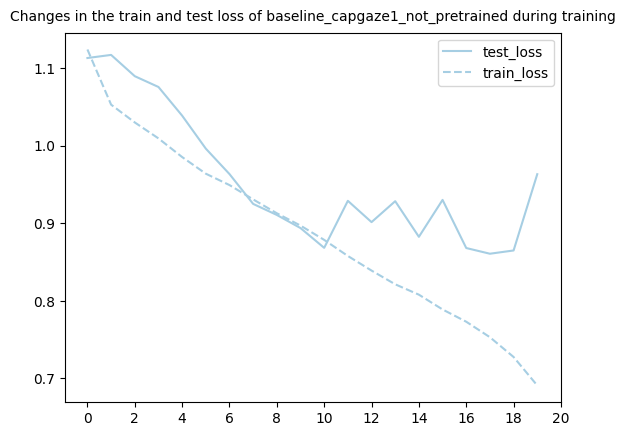

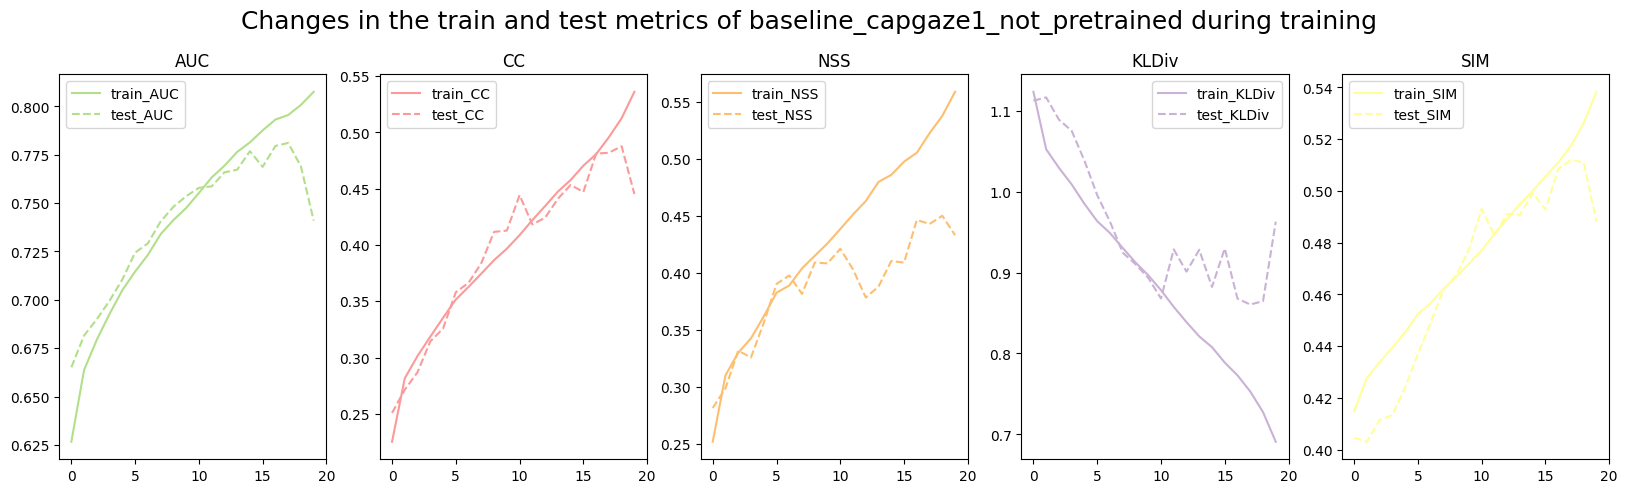

AUC      0.740911
CC       0.445260
NSS      0.433168
KLDiv    0.963038
SIM      0.488066
Name: 19, dtype: float64


In [9]:
create_summary(baseline_capgaze1_not_pretrained, hist_dir, img_dir, train_cols, test_cols, colors)

## Compare the performances of the different models

In [47]:
def plot_losses(model1, model2, hist_dir, train_cols, test_cols, colors):
    model1_train_df, model1_test_df, epochs1 = create_dfs(model1, hist_dir, train_cols, test_cols)
    model2_train_df, model2_test_df, epochs2 = create_dfs(model2, hist_dir, train_cols, test_cols)
    epochs = min(epochs1, epochs2)
    
    model1_test_loss = model1_test_df['test_loss'].to_numpy()
    model1_train_loss = model1_train_df['train_loss'].to_numpy()
    model2_test_loss = model2_test_df['test_loss'].to_numpy()
    model2_train_loss = model2_train_df['train_loss'].to_numpy()
    
    fig, ax = plt.subplots()
    ax.plot(model1_test_loss[:epochs], label=f'{model1}_test_loss', color=colors[0])
    ax.plot(model1_train_loss[:epochs], label=f'{model1}_train_loss', color=colors[0], linestyle='dashed')
    ax.plot(model2_test_loss[:epochs], label=f'{model2}_test_loss', color=colors[1])
    ax.plot(model2_train_loss[:epochs], label=f'{model2}_train_loss', color=colors[1], linestyle='dashed')
    
    ax.set_xticks(np.arange(0, epochs+1, 2))
    ax.set_title(f"Comparison of the train and test losses of {model1} and {model2}", fontsize=10, y=1.01)
    ax.legend()
    
    plt.savefig(f'comparison_loss_{model1}_{model2}.png')
    plt.show();
    
def plot_metrics(model1, model2, hist_dir, train_cols, test_cols, colors):
    model1_train_df, model1_test_df, epochs1 = create_dfs(model1, hist_dir, train_cols, test_cols)
    model2_train_df, model2_test_df, epochs2 = create_dfs(model2, hist_dir, train_cols, test_cols)
    epochs = min(epochs1, epochs2)
    
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharex=True)
    fig.suptitle(f"Comparison of the train and test metrics of {model1} and {model2}", fontsize=14, y=1.01)
    
    for train_metric, test_metric, ax, i in zip(train_cols[1:], test_cols[1:], axs.ravel(), range(0,10,2)):
        model1_train_df[train_metric].iloc[:epochs].plot(label=f'{model1}_{train_metric}', color=colors[i], ax=ax)
        model1_test_df[test_metric].iloc[:epochs].plot(label=f'{model1}_{test_metric}', color=colors[i], linestyle='dashed', ax=ax)
        model2_train_df[train_metric].iloc[:epochs].plot(label=f'{model2}_{train_metric}', color=colors[i+1], ax=ax)
        model2_test_df[test_metric].iloc[:epochs].plot(label=f'{model2}_{test_metric}', color=colors[i+1], linestyle='dashed', ax=ax)
        
        ax.set_title(train_metric.split('_')[1])
        ax.set_xticks(np.arange(0, epochs+1, 5))
        ax.legend(fontsize=6.5)
        
    plt.savefig(f'comparison_metrics_{model1}_{model2}.png')
    plt.show();
    
def compare_performances(model1, model2, hist_dir, train_cols, test_cols, colors):
    plot_losses(model1, model2, hist_dir, train_cols, test_cols, colors)
    plot_metrics(model1, model2, hist_dir, train_cols, test_cols, colors)

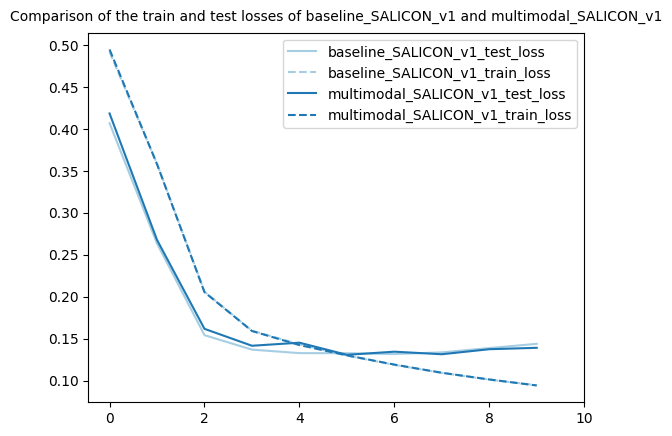

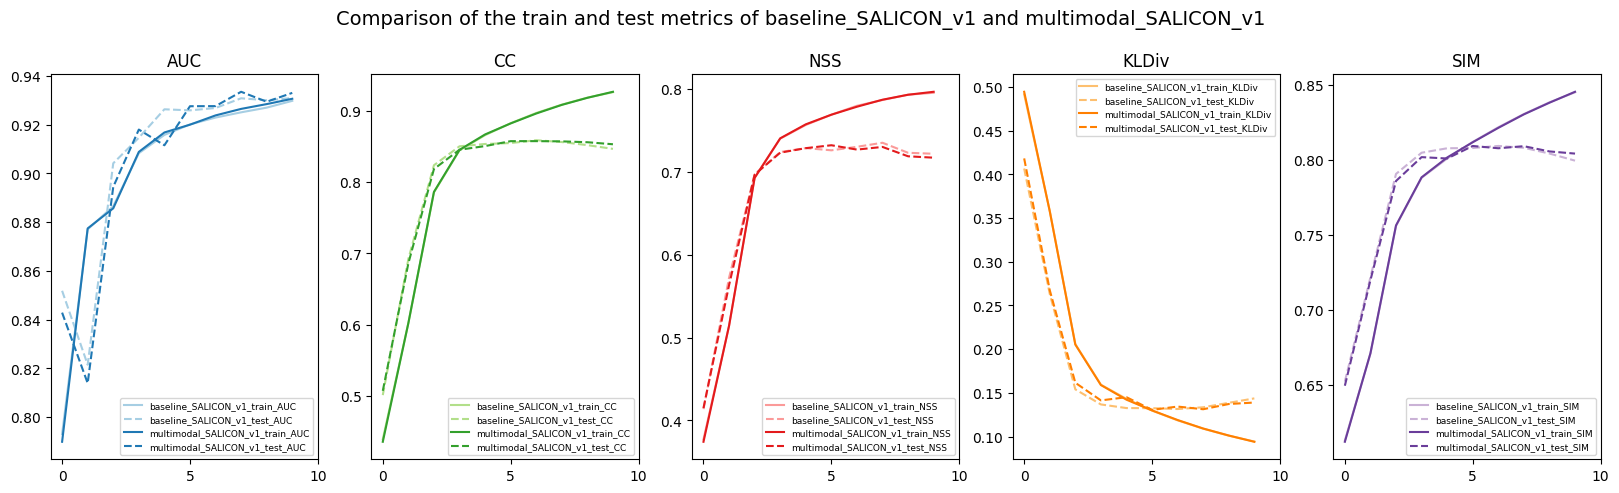

In [43]:
compare_performances(baseline_SALICON, multimodal_SALICON, hist_dir, train_cols, test_cols, colors)

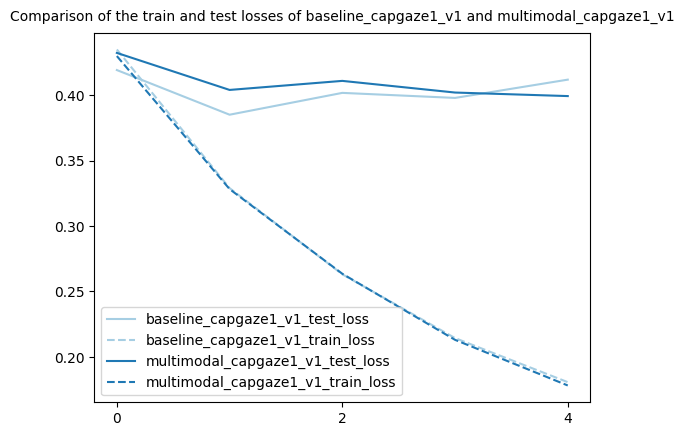

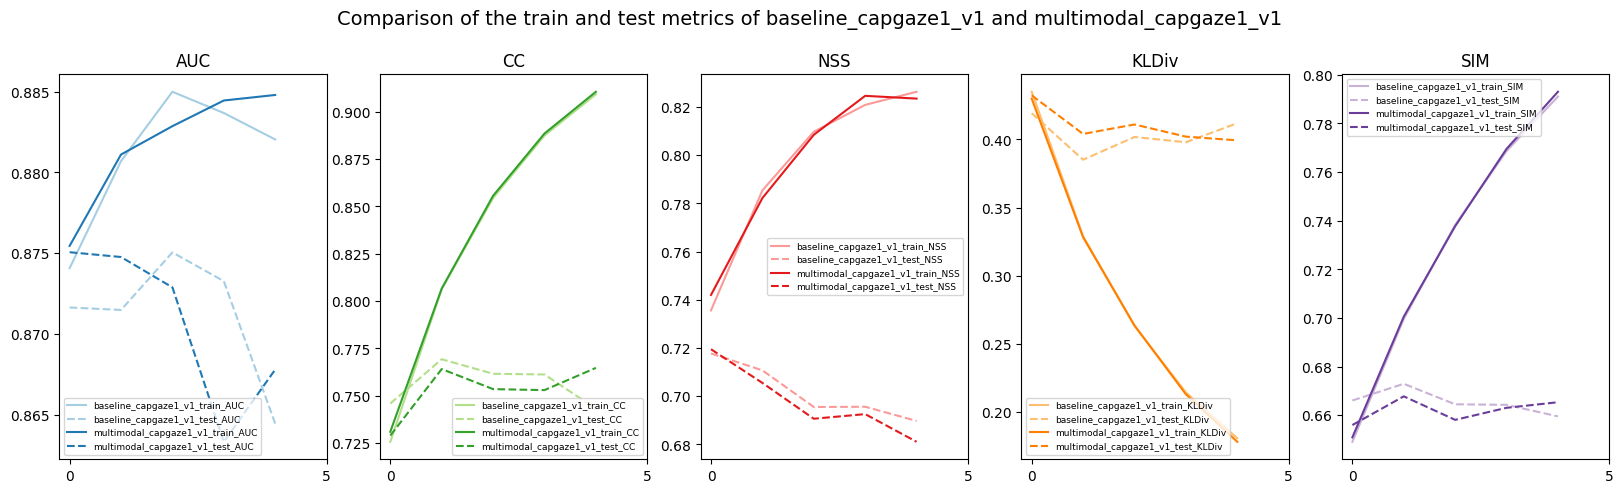

In [44]:
compare_performances(baseline_capgaze1, multimodal_capgaze1, hist_dir, train_cols, test_cols, colors)

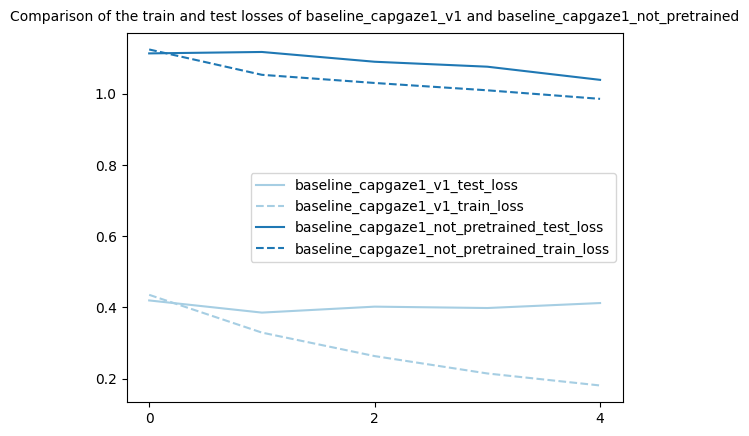

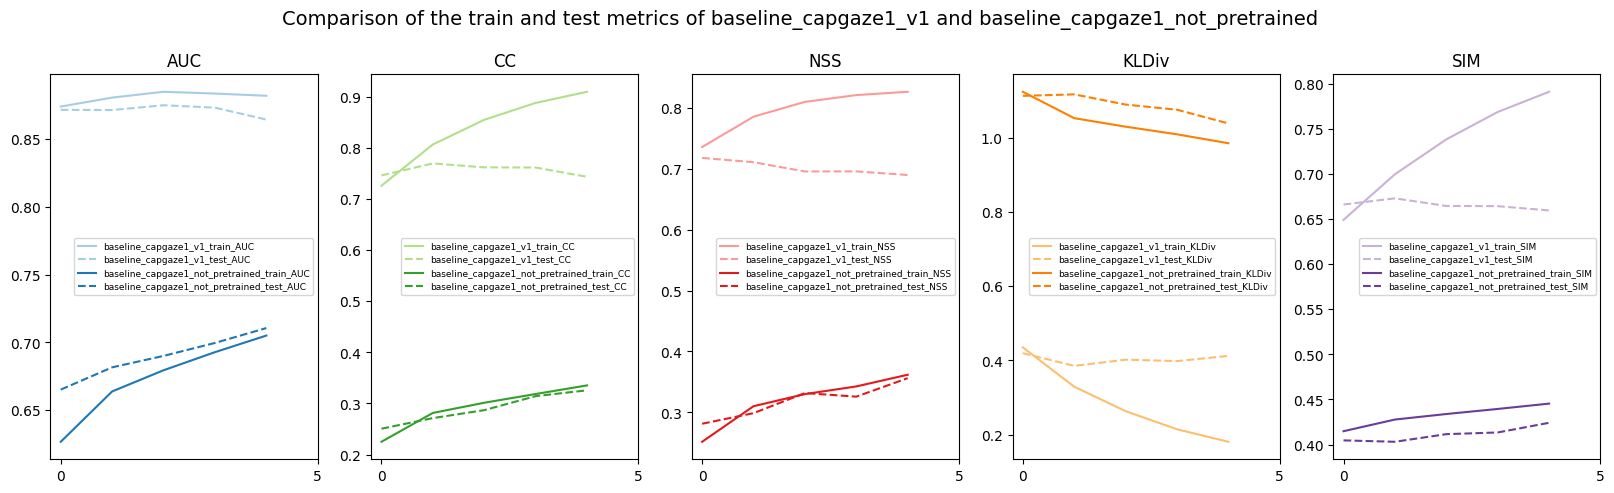

In [48]:
compare_performances(baseline_capgaze1, baseline_capgaze1_not_pretrained, hist_dir, train_cols, test_cols, colors)

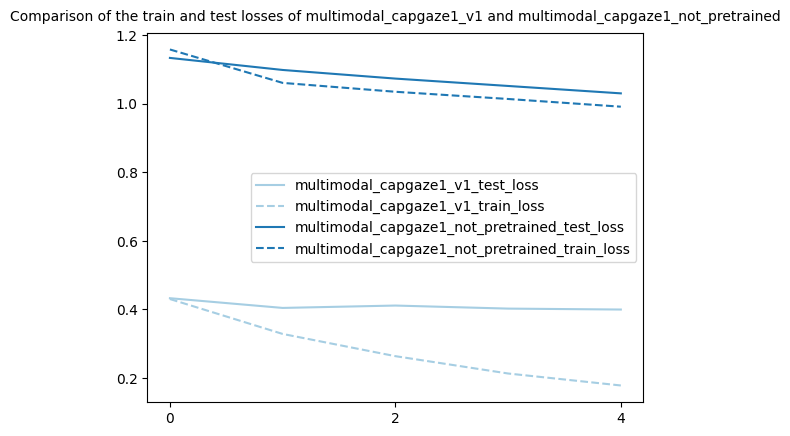

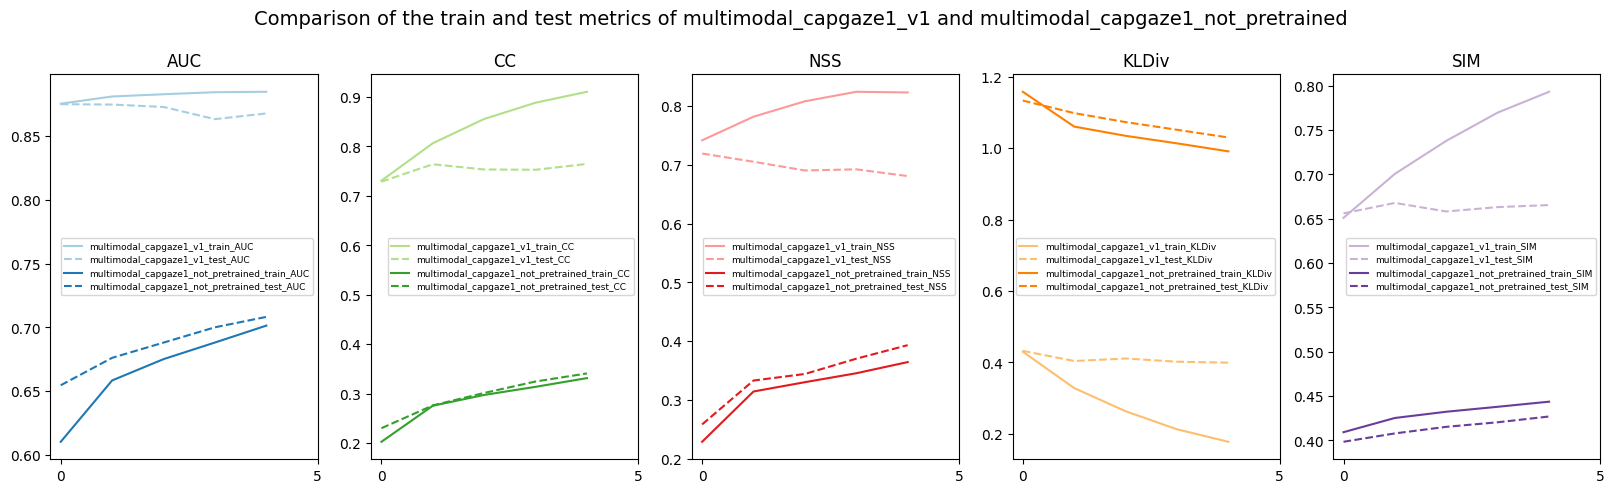

In [49]:
compare_performances(multimodal_capgaze1, multimodal_capgaze1_not_pretrained, hist_dir, train_cols, test_cols, colors)

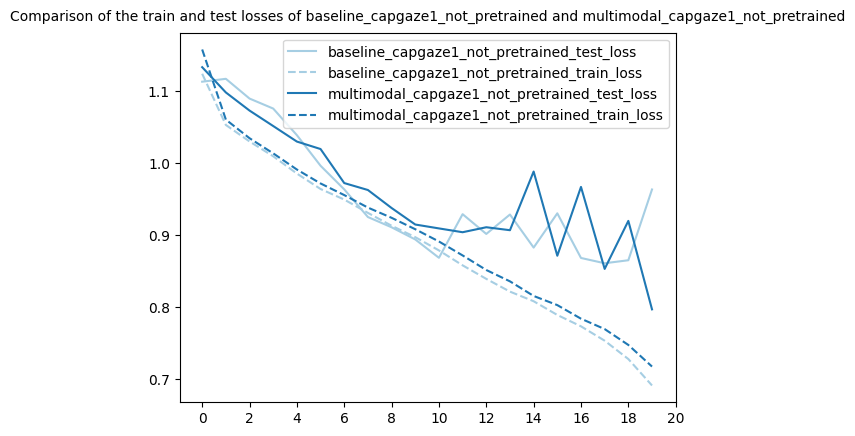

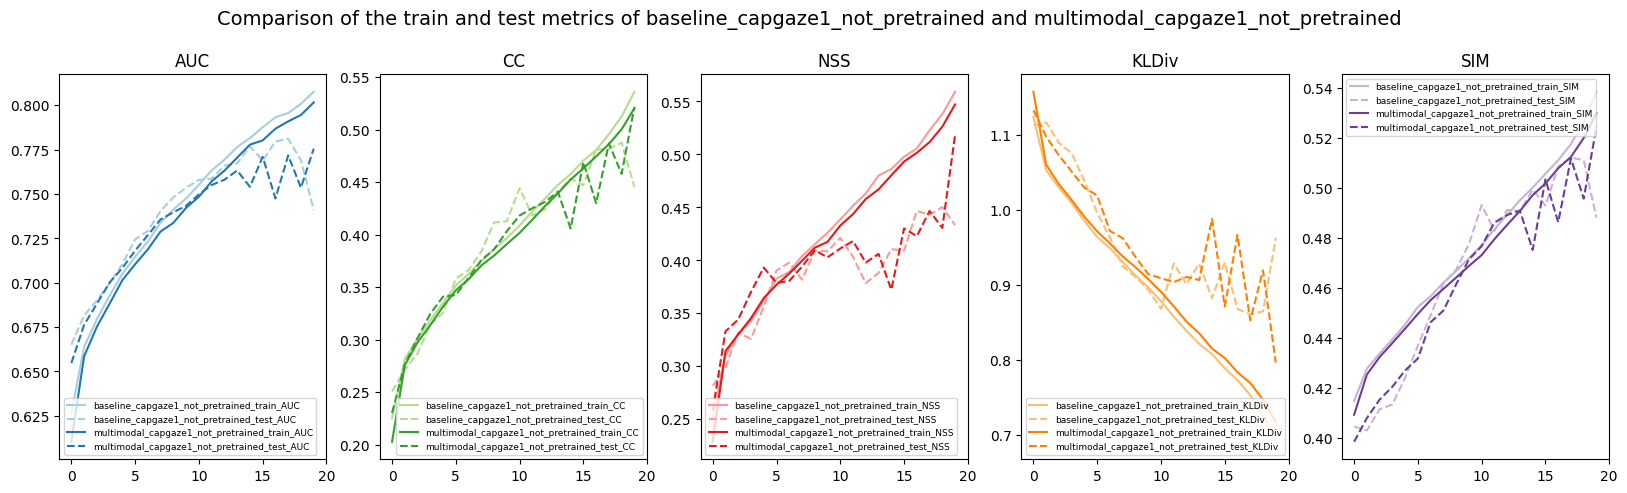

In [50]:
compare_performances(baseline_capgaze1_not_pretrained, multimodal_capgaze1_not_pretrained, hist_dir, train_cols, test_cols, colors)

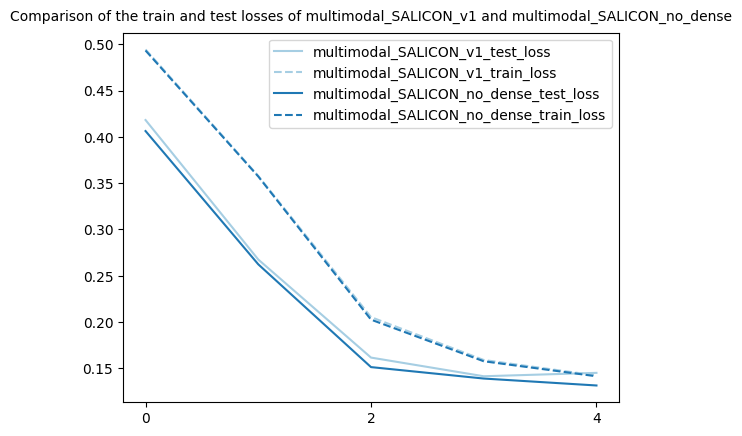

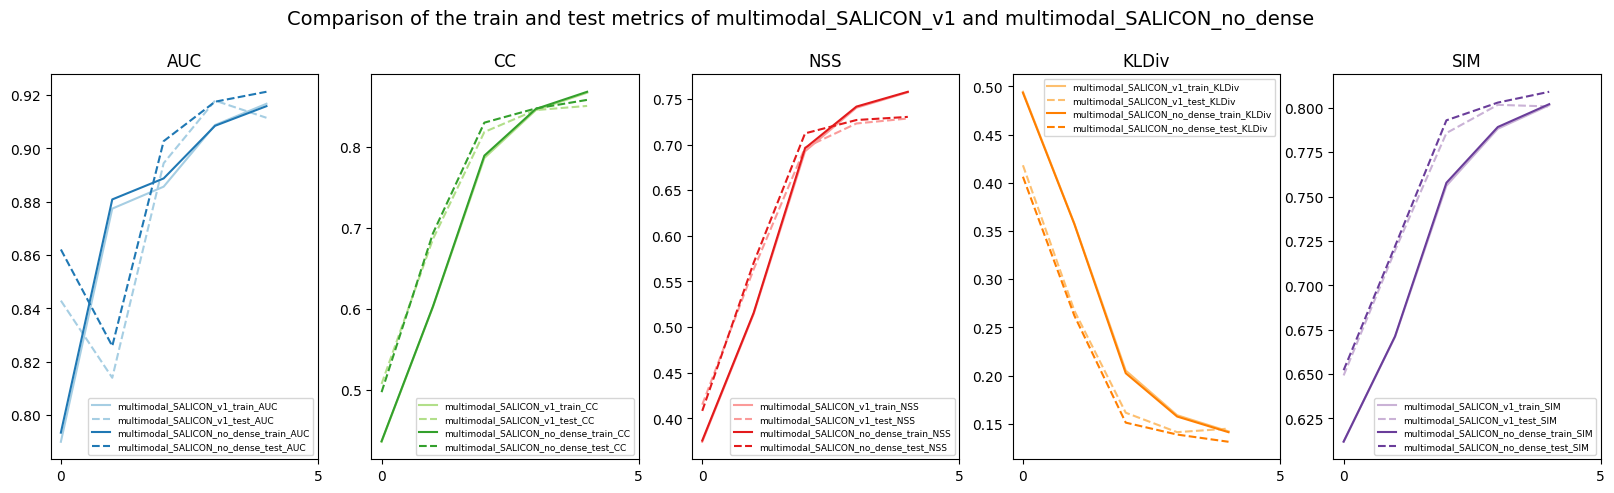

In [51]:
compare_performances(multimodal_SALICON, multimodal_SALICON_no_dense, hist_dir, train_cols, test_cols, colors)